# Using the `Network` object

Let's read in a sample MATSim network into GeNet's `Network` object.

In [1]:
from genet import Network
import os

n = Network('epsg:27700')
path_to_matsim_network = '../example_data/pt2matsim_network'
n.read_matsim_network(os.path.join(path_to_matsim_network, 'network.xml'))
n.read_matsim_schedule(os.path.join(path_to_matsim_network, 'schedule.xml'))
n.print()

Graph info: Name: Network graph
Type: MultiDiGraph
Number of nodes: 1662
Number of edges: 3166
Average in degree:   1.9049
Average out degree:   1.9049 
Schedule info: Schedule:
Number of services: 9
Number of routes: 68
Number of stops: 45


## Summary

The data saved on the edges or nodes of the graph can be nested. There are a couple of convenient methods that summarise the schema of the data found on the nodes and links. If `data=True`, the output also shows up to 5 unique values stored in that location.

In [2]:
n.node_attribute_summary(data=True)

attribute
├── id: ['1230374638', '497215765', '101995', '25257040', '5932883504']
├── x: [528387.4250512555, 528391.4406755936, 528393.2742107178, 528396.6287644263, 528396.3513181042]
├── y: [181547.5850354673, 181552.72935927223, 181558.10532352765, 181559.970402835, 181562.0370527053]
├── lon: [-0.15178558709839862, -0.15872448710537235, -0.13569068709168342, -0.13766218709633904, -0.13543658708819173]
├── lat: [51.51609983324067, 51.5182034332405, 51.51504733324089, 51.522253033239515, 51.522948433239556]
└── s2_id: [5221390710015643649, 5221390314367946753, 5221366508477440003, 5221390682291777543, 5221390739236081673]


In [3]:
n.link_attribute_summary(data=False)

attribute
├── id
├── from
├── to
├── freespeed
├── capacity
├── permlanes
├── oneway
├── modes
├── s2_from
├── s2_to
├── attributes
│   ├── osm:way:access
│   │   ├── name
│   │   ├── class
│   │   └── text
│   ├── osm:way:highway
│   │   ├── name
│   │   ├── class
│   │   └── text
│   ├── osm:way:id
│   │   ├── name
│   │   ├── class
│   │   └── text
│   ├── osm:way:name
│   │   ├── name
│   │   ├── class
│   │   └── text
│   ├── osm:relation:route
│   │   ├── name
│   │   ├── class
│   │   └── text
│   ├── osm:way:lanes
│   │   ├── name
│   │   ├── class
│   │   └── text
│   ├── osm:way:oneway
│   │   ├── name
│   │   ├── class
│   │   └── text
│   ├── osm:way:tunnel
│   │   ├── name
│   │   ├── class
│   │   └── text
│   ├── osm:way:psv
│   │   ├── name
│   │   ├── class
│   │   └── text
│   ├── osm:way:vehicle
│   │   ├── name
│   │   ├── class
│   │   └── text
│   ├── osm:way:traffic_calming
│   │   ├── name
│   │   ├── class
│   │   └── text
│   ├── osm:way:junction
│   │   ├── n

Once you see the general schema for the data stored on nodes and links, you may decide to look at or perform analysis 
on all of the data stored in the netowrk under a particular key. A GeNet network has two methods which generate a
`pandas.Series` object, which stores the nodes or links data present at the specified key, indexed by the same index 
as the nodes or links.

In [4]:
s2_id = n.node_attribute_data_under_key('s2_id')

In [5]:
s2_id

101982       5221390329378179879
101986       5221390328605860387
101990       5221390304444511271
101991       5221390303978897267
101992       5221390304897644929
                    ...         
983839058    5221390693831817171
99936        5221390297975475113
99937        5221390299484831045
99940        5221390294354743413
99943        5221390298004852605
Length: 1662, dtype: int64

In [6]:
n.link_attribute_data_under_key('freespeed').head()

1       4.166667
10      4.166667
100     4.166667
1000    4.166667
1001    4.166667
dtype: float64

Or you can access nested data,

In [7]:
n.link_attribute_data_under_key({'attributes': {'osm:way:lanes': 'text'}}).head()

1007    2
1008    2
1037    2
1038    2
1039    2
dtype: object

You can also build a `pandas.DataFrame` out of several keys.

In [8]:
n.link_attribute_data_under_keys(['freespeed', {'attributes': {'osm:way:highway': 'text'}}]).head()

,freespeed,attributes::osm:way:highway::text
1,4.166667,unclassified
10,4.166667,unclassified
100,4.166667,unclassified
1000,4.166667,residential
1001,4.166667,residential


## Extracting links of interest

The function below gathers link ids which satisfy conditions 
to arbitrary level of nested-ness. It also allows quite flexible conditions---below we require that the link value
at `data['attributes']['osm:way:highway']['text'] == 'primary'`, where data is the data dictionary stored on that link.

In [9]:
from genet import graph_operations

In [10]:
links = n.extract_links_on_edge_attributes(
    conditions= {'attributes': {'osm:way:highway': {'text': 'primary'}}},
)

In [11]:
links[:5]

['1007', '1008', '1023', '1024', '103']

In [12]:
len(links)

619

Below we now require that the link value
at `data['attributes']['osm:way:highway']['text'] in ['primary', 'something else']`. There is nothing in the data that has such tags, so the output is the same.

In [13]:
links = n.extract_links_on_edge_attributes(
    conditions= {'attributes': {'osm:way:highway': {'text': ['primary', 'something else']}}},
)

In [14]:
links[:5]

['1007', '1008', '1023', '1024', '103']

In [15]:
len(links)

619

We can also pass a list of conditions. In this case it makes sense for us to specify how multiple conditions should be handled. We can do it via 
- `how=all` - all conditions need to be met
- `how=any` - at least one condition needs to be met

It is set to `any` as default.

In [16]:
links = n.extract_links_on_edge_attributes(
    conditions= [{'attributes': {'osm:way:highway': {'text': 'primary'}}},
                 {'attributes': {'osm:way:highway': {'text': 'something else'}}}],
    how=any
)

In [17]:
links[:5]

['1007', '1008', '1023', '1024', '103']

In [18]:
len(links)

619

In [19]:
links = n.extract_links_on_edge_attributes(
    conditions= [{'attributes': {'osm:way:highway': {'text': 'primary'}}},
                 {'attributes': {'osm:way:highway': {'text': 'something else'}}}],
    how=all
)

In [20]:
links[:5]

[]

As expected, no links satisfy both `data['attributes']['osm:way:highway']['text'] == 'primary'` and `data['attributes']['osm:way:highway']['text'] == 'something else'`.

Below, we give an example of subsetting a numeric boundary. We find links where `0 <= 'freespeed'  <= 20`.

In [21]:
links = n.extract_links_on_edge_attributes(
    conditions = {'freespeed': (0,20)},
)

In [22]:
links[:5]

['1', '10', '100', '1000', '1001']

In [23]:
len(links)

2334

Finally, we can define a function that will handle the condition for us. The function should take the value expected at the key in the data dictionary and return either `True` or `False`.

For example, below we give an example equivalent to our first example of `data['attributes']['osm:way:highway']['text'] == 'primary'` but using a function we defined ourselves to handle the condition.

In [24]:
def highway_primary(value):
    return value == 'primary'

links = n.extract_links_on_edge_attributes(
    conditions= {'attributes': {'osm:way:highway': {'text': highway_primary}}},
)

In [25]:
links[:5]

['1007', '1008', '1023', '1024', '103']

In [26]:
len(links)

619

This allows for really flexible subsetting of the network based on data stored on the edges. Another example, similar to the numeric boundary, but this time we only care about the upper bound and we make it a strict inequality.

In [27]:
def below_20(value):
    return value < 20

links = n.extract_links_on_edge_attributes(
    conditions= {'freespeed': below_20},
)

In [28]:
links[:5]

['1', '10', '100', '1000', '1001']

In [29]:
len(links)

2334

### Modal convenience methods

### Spatial convenience methods

For spatial extraction conditions you have a choice of:
- `shapely.geometry.Polygon` or `shapely.geometry.GeometryCollection` of Polygons (in epsg:4326)
- geojson file, can be generated with [http://geojson.io/](http://geojson.io/)
- [S2 Geometry hex string which can be generated and copied from http://s2.sidewalklabs.com/regioncoverer](http://s2.sidewalklabs.com/regioncoverer/?center=51.522960%2C-0.144245&zoom=16&cells=48761ad71%2C48761ad723%2C48761ad724c%2C48761ad73c%2C48761ad744%2C48761ad75d3%2C48761ad75d5%2C48761ad765%2C48761ad767%2C48761ad76c%2C48761ad774%2C48761ad779%2C48761ad77b%2C48761ad783%2C48761ad784c%2C48761ad7854%2C48761ad794%2C48761ad79c%2C48761ad7a4%2C48761ad7ac%2C48761ad7b1%2C48761ad7bc)


In [30]:
from genet.outputs_handler.geojson import generate_geodataframes
gdf_nodes, gdf_links = generate_geodataframes(n.graph)

/Users/kasia.kozlowska/pycharm_venvs/genet/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [31]:
region = '48761ad71,48761ad723,48761ad724c,48761ad73c,48761ad744,48761ad75d3,48761ad75d5,48761ad765,48761ad767,48761ad76c,48761ad774,48761ad779,48761ad77b,48761ad783,48761ad784c,48761ad7854,48761ad794,48761ad79c,48761ad7a4,48761ad7ac,48761ad7b1,48761ad7bc'
_nodes = n.nodes_on_spatial_condition(region)[:5]
len(_nodes)

5

(<matplotlib.axes._subplots.AxesSubplot at 0x11a09db70>,
 <matplotlib.axes._subplots.AxesSubplot at 0x11a0fcd30>)

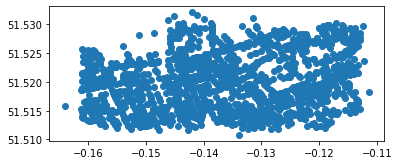

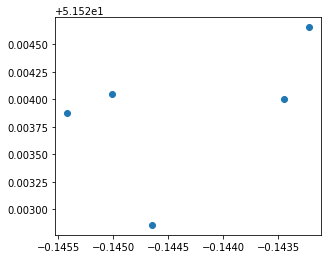

In [32]:
gdf_nodes.plot(), gdf_nodes[gdf_nodes['id'].isin(_nodes)].plot()

In [33]:
geojson = '../example_data/Fitzrovia_polygon.geojson'

# here the area is too small for any routes to be within it
_links = n.links_on_spatial_condition(geojson, how='intersect')
len(_links)

/Users/kasia.kozlowska/pycharm_venvs/genet/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


270

(<matplotlib.axes._subplots.AxesSubplot at 0x119a73e80>,
 <matplotlib.axes._subplots.AxesSubplot at 0x119bc8160>)

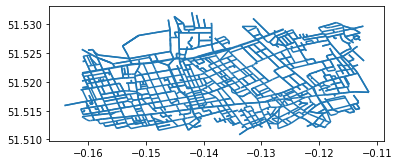

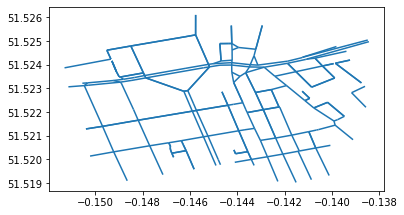

In [34]:
gdf_links.plot(), gdf_links[gdf_links['id'].isin(_links)].plot()

In [35]:
from shapely.geometry import Polygon

region = Polygon([
    (-0.1487016677856445, 51.52556684350165), (-0.14063358306884766, 51.5255134425896),
    (-0.13865947723388672, 51.5228700191647), (-0.14093399047851562, 51.52006622056997),
    (-0.1492595672607422, 51.51974577545329), (-0.1508045196533203, 51.52276321095246),
    (-0.1487016677856445, 51.52556684350165)])

_links = n.links_on_spatial_condition(region, how='within')
len(_links)

/Users/kasia.kozlowska/pycharm_venvs/genet/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


227

(<matplotlib.axes._subplots.AxesSubplot at 0x11978c978>,
 <matplotlib.axes._subplots.AxesSubplot at 0x119898b00>)

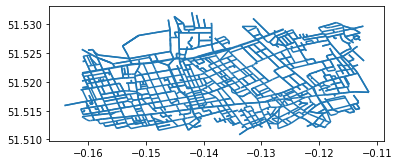

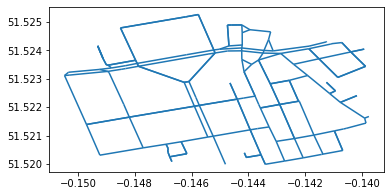

In [36]:
gdf_links.plot(), gdf_links[gdf_links['id'].isin(_links)].plot()

# Using the `Schedule` object
`Schedule` is a representation of public transit and is a part of any `genet.Network`, it is initiated as empty. A Network can exist and still be valid with an empty `Schedule`. Earlier we read a MATSim transit schedule. 

A `Schedule` is comprised of a number of nested objects. Each `Schedule` has a number of `Service`s. Each `Service` is made up a number of `Route`s. A `Route` is defined by an ordered list of `Stop` objects. Every `Service` should, logically, have at least two `Route`s, one going in one direction and another going back. Each `Route` also hold information about the trips, their timing and offsets arriving and departing at the `Stop`s.

We can look at quick stats:

In [37]:
n.schedule.print()

Schedule:
Number of services: 9
Number of routes: 68
Number of stops: 45


Or we can plot the `Schedule` object. A `Schedule` on its' own does not have information about the `Network`, even if it has refrences to it via network routes in the `Route` objects. Thus calling a `plot` method on a Schedule will result in a plot of connections between stops for all `Route`s within all `Service`s. To plot the network routes of the `Schedule` we use the `plot` method for the `Network` object which holds that `Schedule`.

/Users/kasia.kozlowska/pycharm_venvs/genet/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/Users/kasia.kozlowska/pycharm_venvs/genet/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


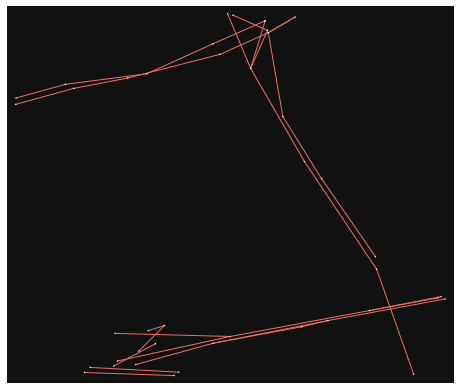

(<Figure size 576x576 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x119a7f940>)

In [38]:
n.schedule.plot()

## Summary
Schedules can get large and complicated. GeNet includes methods similar to ones presented for `Network` objects. This time, instead of inspecting data stored on links and edges of a graph, we summarise data held for Stops, Routes and Services in the Schedule.

In [63]:
n.schedule.stop_attribute_summary(data=False)

attribute
├── services
├── routes
├── id
├── x
├── y
├── epsg
├── name
├── lat
├── lon
├── s2_id
├── additional_attributes
├── linkRefId
└── isBlocking


In [40]:
n.schedule.route_attribute_summary(data=True)

attribute
├── route_short_name: ['N20', '134', 'N55', '98', 'N5']
├── mode: ['bus']
├── trips
│   ├── VJ2cdccea96e0e3e6a53a968bcb132941415d6d7c9_04:53:00: ['04:53:00']
│   ├── VJ375a660d47a2aa570aa20a8568012da8497ffecf_03:53:00: ['03:53:00']
│   ├── VJ3b9d77d2ef200b21c8048fea5eedc2d2788a1b94_01:54:00: ['01:54:00']
│   ├── VJ79974c386a39426e06783650a759828438432aa4_05:23:00: ['05:23:00']
│   ├── VJa09c394b71031216571d813a6266c83f2d30bf0a_04:23:00: ['04:23:00']
│   ├── VJb1ecf6f30844187f7b9364fd9550acdcc5ce2c22_01:25:00: ['01:25:00']
│   ├── VJc22488e687bcce9c50e372806cd8a1bcdddd5f98_02:24:00: ['02:24:00']
│   ├── VJc3fd8f2be7eb005d47a13119c129d23ba6fed5fd_03:23:00: ['03:23:00']
│   ├── VJe80a8ff48d21b29919ca3d8234d5a86bbf729513_02:54:00: ['02:54:00']
│   ├── VJe81073fff46cfb30ff47a53f387e05dc17f2dda3_24:55:00: ['24:55:00']
│   ├── VJ4bf97582df9fc4d0ac8bba408ff3f377f362159c_02:10:00: ['02:10:00']
│   ├── VJ812fad65e7fa418645b57b446f00cba573f2cdaf_01:10:00: ['01:10:00']
│   ├── VJ8e65ca22

In [41]:
n.schedule.service_attribute_summary(data=True)

attribute
├── id: ['12430', '20274', '17732', '15234', '15660']
└── name: ['N8', 'N20', '134', 'N55', '98']


Again, similarly to `Network` objects, we can generate `pandas.DataFrame`s for chosen attributes of Stops, Routes and Services. These dataframes are indexed by the index of the object you query, i.e. Stop ID, Route ID or Service ID. During intantiation of a Schedule object, Route and Service indices are checked and forced to be unique, reindexing them as neccessary.

In [42]:
n.schedule.stop_attribute_data(keys=['lat', 'lon', 'name']).head()

,lat,lon,name
490000235X.link:834,51.516685,-0.128096,Tottenham Court Road Station (Stop X)
490000235YB.link:574,51.516098,-0.134044,Oxford Street Soho Street (Stop YB)
490014214HE.link:3154,51.515923,-0.135392,Wardour Street (Stop OM)
490010689KB.link:981,51.515472,-0.139893,Great Titchfield Street Oxford Circus Station...
490000235P.link:15,51.516762,-0.128295,Tottenham Court Road Station New Oxford Stree...


In [43]:
n.schedule.route_attribute_data(keys=['route_short_name', 'mode']).head()

,route_short_name,mode
VJ375a660d47a2aa570aa20a8568012da8497ffecf,N55,bus
VJ812fad65e7fa418645b57b446f00cba573f2cdaf,N55,bus
VJ6c64ab7b477e201cae950efde5bd0cb4e2e8888e,N55,bus
VJb08f8a2de01a4ef99d3b7fefd9022117ac307531,N5,bus
VJ06cd41dcd58d947097df4a8f33234ef423210154,205,bus


In [44]:
n.schedule.service_attribute_data(keys='name', index_name='service_id').head()

,name
service_id,
20274,N55
12430,205
17732,N20
15234,134
15660,113


## Extracting Stops, Routes, Services of interest

There are times when we need to extract Service, Route or Stop IDs depending on some logic. Building conditions works exactly the same as for links and nodes of `genet.Network` which was presented exhaustively above. Here we present some examples. There are separate methods for `Service`, `Route` or `Stop` objects that return the IDs of these objects if they satisfy the conditions given by the user. Note, `attribute_summary` methods presented above help in building these conditions.

### In general

In [45]:
n.schedule.extract_service_ids_on_attributes(
    conditions={'name': 'N55'})

['20274']

In [46]:
n.schedule.extract_route_ids_on_attributes(
    conditions=[{'mode': 'bus'}, {'route_short_name': 'N55'}], how=all)[:5]

['VJ375a660d47a2aa570aa20a8568012da8497ffecf',
 'VJ812fad65e7fa418645b57b446f00cba573f2cdaf',
 'VJ6c64ab7b477e201cae950efde5bd0cb4e2e8888e']

In [47]:
def oxford_street_in_name(attribs):
    if 'Oxford Street' in attribs:
        return True
    else:
        return False

n.schedule.extract_stop_ids_on_attributes(
    conditions={'name': oxford_street_in_name})[:5]

['490000235YB.link:574',
 '490000235P.link:15',
 '490000173W.link:1868',
 '490000235Z.link:15']

There are several common extraction logics we might need. They relate to modes and spatial and temporal logic. Below we go through some convenience methods for those.

### Modal

Below are convenience methods for extracting object IDs based on the modes they are related to. Note that only `Route` objects actually hold information about their mode of transport. When we extract `Service` of mode `x`, we pick services whose at least one route is of that mode. Similarly with `Stop`s, we extract those used by routes of that mode.

In [48]:
n.schedule.services_on_modal_condition(modes='bus')[:5]

['20274', '12430', '17732', '15234', '15660']

In [49]:
n.schedule.routes_on_modal_condition(modes=['bus', 'rail'])[:5]

['VJ375a660d47a2aa570aa20a8568012da8497ffecf',
 'VJ812fad65e7fa418645b57b446f00cba573f2cdaf',
 'VJ6c64ab7b477e201cae950efde5bd0cb4e2e8888e',
 'VJb08f8a2de01a4ef99d3b7fefd9022117ac307531',
 'VJ06cd41dcd58d947097df4a8f33234ef423210154']

In [50]:
n.schedule.stops_on_modal_condition(modes='bus')[:5]

['490000235X.link:834',
 '490000235YB.link:574',
 '490014214HE.link:3154',
 '490010689KB.link:981',
 '490000235P.link:15']

### Spatial

For spatial extraction conditions, similarly to the `Network` object, you have a choice of:
- `shapely.geometry.Polygon` or `shapely.geometry.GeometryCollection` of Polygons (in epsg:4326)
- geojson file, can be generated with [http://geojson.io/](http://geojson.io/)
- [S2 Geometry hex string which can be generated and copied from http://s2.sidewalklabs.com/regioncoverer](http://s2.sidewalklabs.com/regioncoverer/?center=51.522960%2C-0.144245&zoom=16&cells=48761ad71%2C48761ad723%2C48761ad724c%2C48761ad73c%2C48761ad744%2C48761ad75d3%2C48761ad75d5%2C48761ad765%2C48761ad767%2C48761ad76c%2C48761ad774%2C48761ad779%2C48761ad77b%2C48761ad783%2C48761ad784c%2C48761ad7854%2C48761ad794%2C48761ad79c%2C48761ad7a4%2C48761ad7ac%2C48761ad7b1%2C48761ad7bc)

Again, methods exist for `Service`, `Route` or `Stop` objects seperately.

In [51]:
from shapely.geometry import Polygon

region = Polygon([
    (-0.1487016677856445, 51.52556684350165), (-0.14063358306884766, 51.5255134425896),
    (-0.13865947723388672, 51.5228700191647), (-0.14093399047851562, 51.52006622056997),
    (-0.1492595672607422, 51.51974577545329), (-0.1508045196533203, 51.52276321095246),
    (-0.1487016677856445, 51.52556684350165)])

n.schedule.services_on_spatial_condition(region)

/Users/kasia.kozlowska/pycharm_venvs/genet/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


['12430']

There are two options for `Service` and `Route` objects. They can either `intersect` the area, meaning at least one of their `Stop`s lie in the specified area, or be `within` this area.

In [52]:
geojson = '../example_data/Fitzrovia_polygon.geojson'

# here the area is too small for any routes to be within it
n.schedule.routes_on_spatial_condition(geojson, how='within')

/Users/kasia.kozlowska/pycharm_venvs/genet/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


[]

In [53]:
# a lot of routes intersect it however
n.schedule.routes_on_spatial_condition(geojson, how='intersect')[:5]

/Users/kasia.kozlowska/pycharm_venvs/genet/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


['VJ06cd41dcd58d947097df4a8f33234ef423210154',
 'VJf8e38a73359b6cf743d8e35ee64ef1f7b7914daa',
 'VJef7f20c3a9bf1419f6401e1e9131fe2c634bcb9a',
 'VJ0f3c08222de16c2e278be0a1bf0f9ea47370774e',
 'VJeae6e634f8479e0b6712780d5728f0afca964e64']

In [54]:
hex_region = '48761ad71,48761ad723,48761ad724c,48761ad73c,48761ad744,48761ad75d3,48761ad75d5,48761ad765,48761ad767,48761ad76c,48761ad774,48761ad779,48761ad77b,48761ad783,48761ad784c,48761ad7854,48761ad794,48761ad79c,48761ad7a4,48761ad7ac,48761ad7b1,48761ad7bc'
n.schedule.stops_on_spatial_condition(hex_region)

['490000091H.link:1912', '490000091G.link:1242']

### Temporal

These methods are under construction. A useful one in the meantime is presented below. It generates a `pandas.DataFrame` of departure and arrival times between all stops for all trips.

In [55]:
n.schedule.generate_trips_dataframe(gtfs_day='20200101').head()

,arrival_time,mode,service_name,from_stop_name,route,from_stop,departure_time,to_stop_name,service,to_stop,route_name,trip
0,2020-01-01 16:35:25,bus,205,Euston Square (Stop P),VJ06420fdab0dfe5c8e7f2f9504df05cf6289cd7d3,490000078P.link:1383,2020-01-01 16:33:42,University College Hosp Warren Street Stn (Sto...,12430,4900020147W.link:2634,205,VJ03f4f8905d6dc7868242f3fd29828ee9b366a906_16:...
1,2020-01-01 16:37:08,bus,205,University College Hosp Warren Street Stn (Sto...,VJ06420fdab0dfe5c8e7f2f9504df05cf6289cd7d3,4900020147W.link:2634,2020-01-01 16:35:25,Warren Street Station (Stop V),12430,490000252V.link:1182,205,VJ03f4f8905d6dc7868242f3fd29828ee9b366a906_16:...
2,2020-01-01 16:38:51,bus,205,Warren Street Station (Stop V),VJ06420fdab0dfe5c8e7f2f9504df05cf6289cd7d3,490000252V.link:1182,2020-01-01 16:37:08,Great Portland Street (Stop G),12430,490000091G.link:1242,205,VJ03f4f8905d6dc7868242f3fd29828ee9b366a906_16:...
3,2020-01-01 16:40:34,bus,205,Great Portland Street (Stop G),VJ06420fdab0dfe5c8e7f2f9504df05cf6289cd7d3,490000091G.link:1242,2020-01-01 16:38:51,Regent's Park (Stop B),12430,490000191B.link:305,205,VJ03f4f8905d6dc7868242f3fd29828ee9b366a906_16:...
4,2020-01-01 16:42:17,bus,205,Regent's Park (Stop B),VJ06420fdab0dfe5c8e7f2f9504df05cf6289cd7d3,490000191B.link:305,2020-01-01 16:40:34,Harley Street (Stop L),12430,490007807W.link:2922,205,VJ03f4f8905d6dc7868242f3fd29828ee9b366a906_16:...


## Accessing `Stop`, `Route`, `Service` objects

Once you extract IDs of interest, you can access these objects. You can also modify them, check out the Modify Network notebook for usage examples.

Each `Service` is indexed and can be accessed by its' ID. It also has a plot method.

In [56]:
n.schedule.service_ids()[:5]

['20274', '12430', '17732', '15234', '15660']

In [57]:
service = n.schedule['12430']
service.print()

Service ID: 12430
Name: 205
Number of routes: 12
Number of stops: 11


/Users/kasia.kozlowska/pycharm_venvs/genet/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/Users/kasia.kozlowska/pycharm_venvs/genet/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


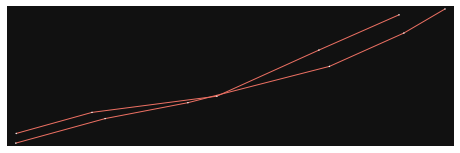

(<Figure size 576x576 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x119de4ef0>)

In [58]:
service.plot()

Similarly, each `Route` is indexed and can be accessed by its' id. It also has a plot method.

In [59]:
n.schedule.route_ids()[:5]

['VJ375a660d47a2aa570aa20a8568012da8497ffecf',
 'VJ812fad65e7fa418645b57b446f00cba573f2cdaf',
 'VJ6c64ab7b477e201cae950efde5bd0cb4e2e8888e',
 'VJb08f8a2de01a4ef99d3b7fefd9022117ac307531',
 'VJ06cd41dcd58d947097df4a8f33234ef423210154']

In [60]:
route = n.schedule.route('VJ948e8caa0f08b9c6bf6330927893942c474b5100')
route.print()

Route ID: VJ948e8caa0f08b9c6bf6330927893942c474b5100
Name: 205
Number of stops: 5
Number of trips: 10


/Users/kasia.kozlowska/pycharm_venvs/genet/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


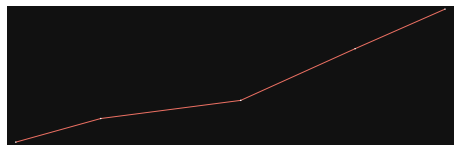

(<Figure size 576x576 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x119dea710>)

In [61]:
route.plot()

Finally, each `Stop` is indexed too, and can be accessed by its' id. 

In [62]:
stop = n.schedule.stop('490007807E.link:1154')
stop.print()

Stop ID: 490007807E.link:1154
Projection: epsg:27700
Lat, Lon: 51.52336503, -0.14951799
linkRefId: 1154
